## Object detection with TensorFlow 2 Object detection API

Dataset is obtained from [Kaggle](https://www.kaggle.com/datasets/lplenka/coco-car-damage-detection-dataset).

Click the image below to read the post online. 

<a target="_blank" href="https://www.machinelearningnuggets.com/object-detection-with-tensorflow-2-object-detection-api"><img src="https://www.machinelearningnuggets.com/content/images/2022/06/logo.png" alt="Open in ML Nuggets"></a>

### Download dataset and other essential files

In [ ]:
!git clone https://github.com/mlnuggets/maskrcnn.git

### Install TensorFlow 2 Object Detection API on Colab

In [ ]:
!git clone https://github.com/tensorflow/models.git

In [ ]:
%%bash
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf2/setup.py .
python -m pip install --use-feature=2020-resolver .

### Download Mask RCNN model

In [ ]:
pip install wget 

In [5]:
import wget

In [6]:
model_link = "http://download.tensorflow.org/models/object_detection/tf2/20200711/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz"
wget.download(model_link)

'mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz'

In [7]:
import tarfile
tar = tarfile.open('/content/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz')
tar.extractall('.') 
tar.close()

### install right OpenCV version

In [ ]:
pip uninstall opencv-python-headless==4.5.5.62

In [ ]:
pip install opencv-python-headless==4.5.2.52

### Install right version of libcudnn8

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

### Convert the data to TFRecords

In [ ]:
!python /content/maskrcnn/create_coco_tf_record.py --logtostderr \
      --train_image_dir=/content/maskrcnn/data/train  \
      --test_image_dir=/content/maskrcnn/data/val \
      --train_annotations_file=/content/maskrcnn/data/train/COCO_mul_train_annos.json \
      --test_annotations_file=/content/maskrcnn/data/val/COCO_mul_val_annos.json \
      --output_dir=/content/maskrcnn/data/tf_records

## Train the model

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py\
    --pipeline_config_path=/content/maskrcnn/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8-colab.config \
    --model_dir=/content/training \
    --alsologtostderr

In [13]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder
%matplotlib inline


In [14]:
num_classes = 5

In [21]:
pipeline_file = '/content/maskrcnn/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8-colab.config'
last_model_path = '/content/training/'
output_directory = "/content/finetuned-maskrcnn"

In [22]:
#see where our model saved weights
%ls '/content/training/'

checkpoint                  ckpt-1.index                ckpt-2.index
ckpt-1.data-00000-of-00001  ckpt-2.data-00000-of-00001  train/


In [ ]:
!python /content/models/research/object_detection/exporter_main_v2.py \
    --input_type="image_tensor" \
    --pipeline_config_path {pipeline_file} \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory={output_directory}

### Run conversion script

In [ ]:
#run conversion script
import re
import numpy as np

output_directory = '/content/fine_tuned_model'

#place the model weights you would like to export here
last_model_path = '/content/training/'
print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

### Download model from Colab

In [ ]:
!zip -r /content/maskrcnn.zip /content/training
from google.colab import files
files.download("/content/maskrcnn.zip")

In [ ]:
!zip -r /content/fine_tuned_model.zip /content/fine_tuned_model
from google.colab import files
files.download("/content/fine_tuned_model.zip")

In [27]:
%ls '/content/fine_tuned_model/saved_model/'

assets/  saved_model.pb  variables/


### Load an image from file into a numpy array

In [28]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


### Visualize detections

In [29]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

## Create model from the last checkpoint

In [ ]:
import pathlib

filenames = list(pathlib.Path('/content/training/').glob('*.index'))

filenames.sort()
print(filenames)

#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

## Map labels for inference decoding

In [31]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

### Run detector on test image

In [ ]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

TEST_IMAGE_PATHS = glob.glob('/content/maskrcnn/data/test/*.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.axis("off")
plt.show()

## Use model for image segmentation

In [38]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [39]:
def load_model(model_dir):
    
    model = tf.saved_model.load(str(model_dir))
    return model

In [40]:
model_dir = '/content/finetuned-maskrcnn/saved_model'
masking_model = load_model(model_dir)

### Set label map

In [41]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/maskrcnn/data/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Set test image paths

In [ ]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/maskrcnn/data/test')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

### Create inference function

In [43]:
import itertools

def run_inference_for_single_image(model, image_np):
    
    print("Running inference for : ",image_path)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop("num_detections"))

    detections = dict(itertools.islice(detections.items(), num_detections))

    detections["num_detections"] = num_detections

    image_np_with_detections = image_np.copy()

    # Handle models with masks:
    if "detection_masks" in detections:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              detections["detection_masks"][0], detections["detection_boxes"][0],
               image_np.shape[0], image_np.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        detections["detection_masks_reframed"] = detection_masks_reframed.numpy()

    boxes = np.asarray(detections["detection_boxes"][0])
    classes = np.asarray(detections["detection_classes"][0]).astype(np.int64)
    scores = np.asarray(detections["detection_scores"][0])
    mask = np.asarray(detections["detection_masks_reframed"])

    # Visualizing the results
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        boxes,
        classes,
        scores,
        category_index,
        instance_masks=mask,
        use_normalized_coordinates=True,
        line_thickness=3)
    
    # Display image with detections and segmented parts
    display(Image.fromarray(image_np_with_detections))

In [44]:
def show_inference(model, image_path):

    # Load image
    image_np = np.array(Image.open(image_path))
    
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)


## Perform segmentation and detection

Running inference for :  /content/maskrcnn/data/test/11.jpg


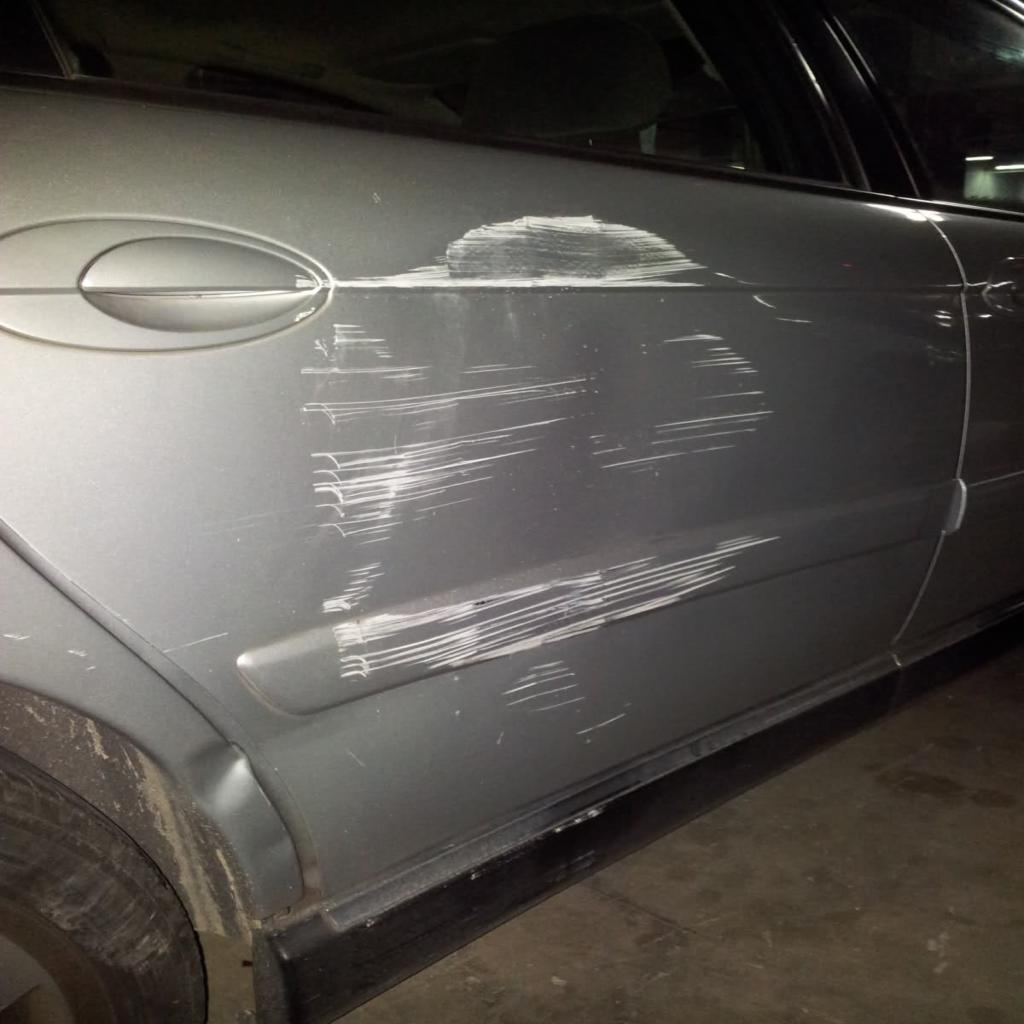

Running inference for :  /content/maskrcnn/data/test/12.jpg


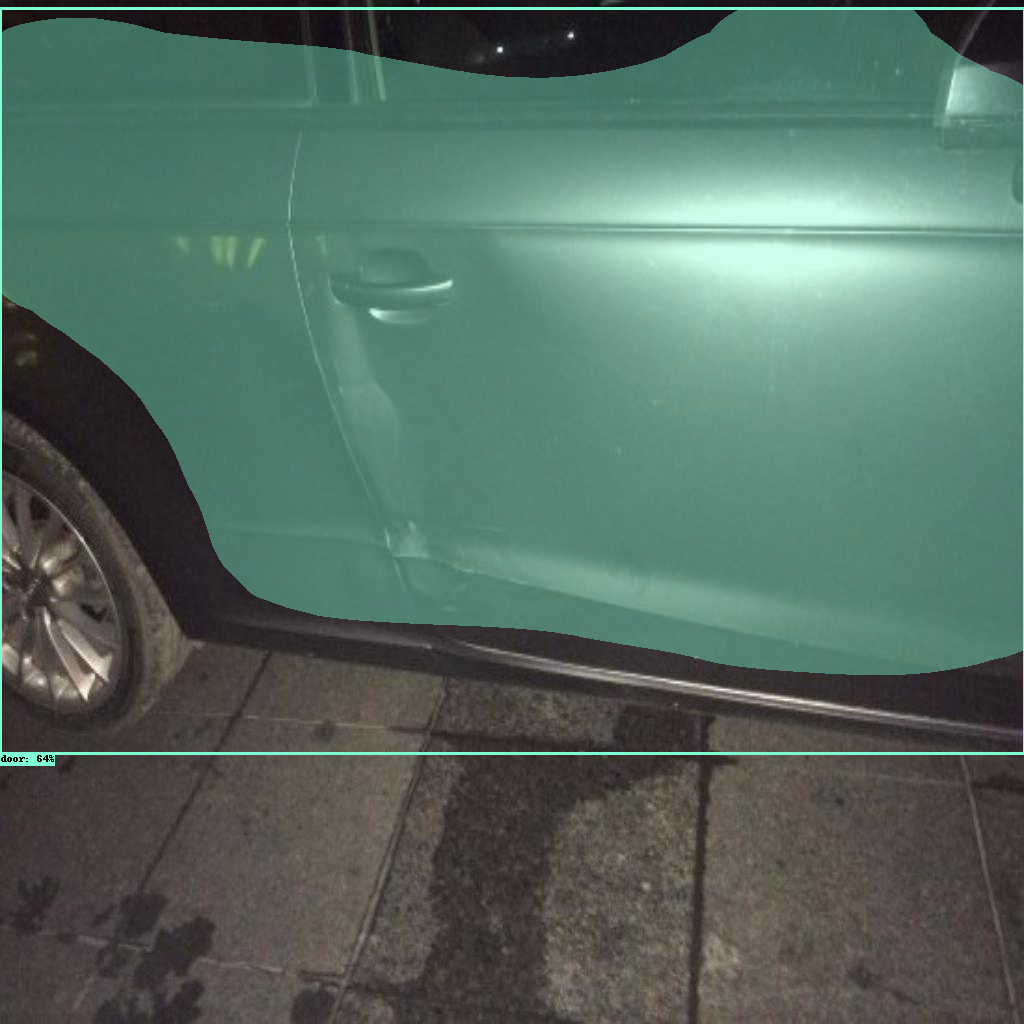

Running inference for :  /content/maskrcnn/data/test/28.jpg


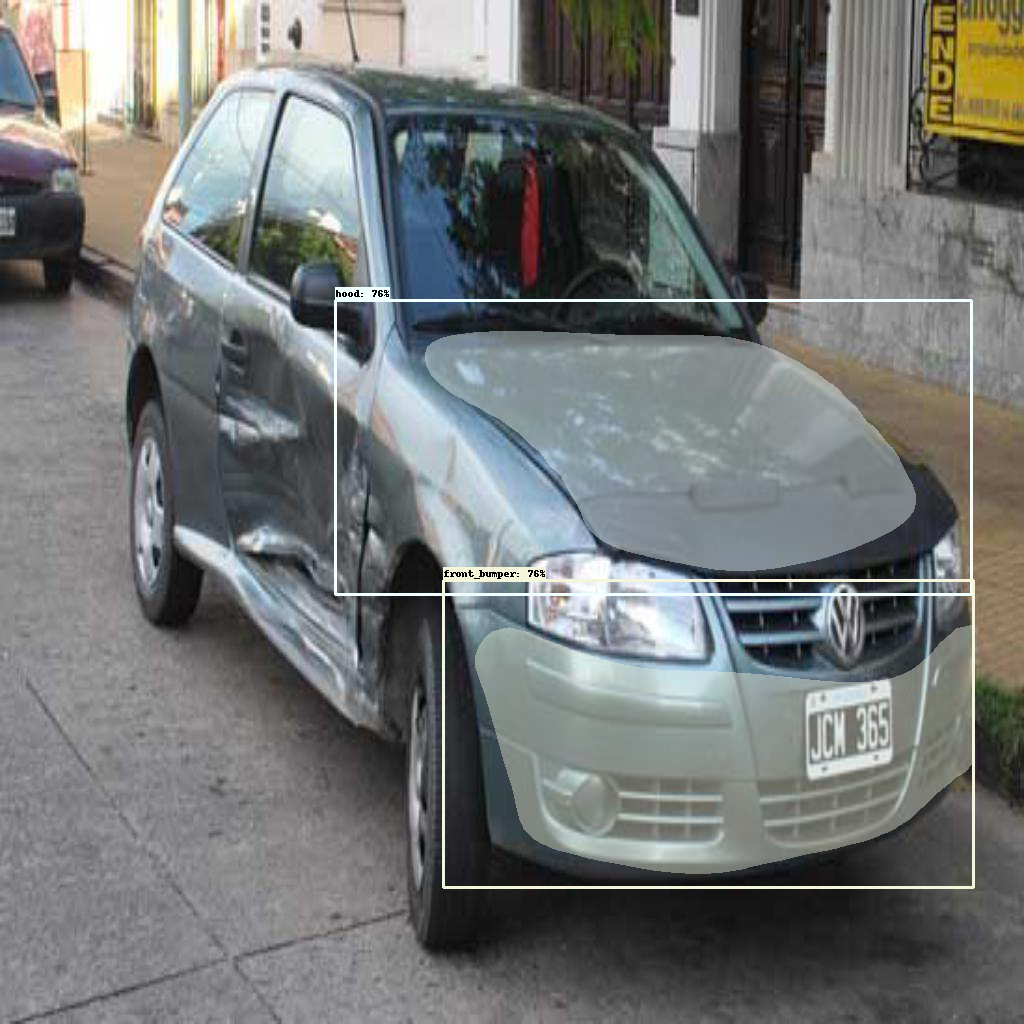

Running inference for :  /content/maskrcnn/data/test/45.jpg


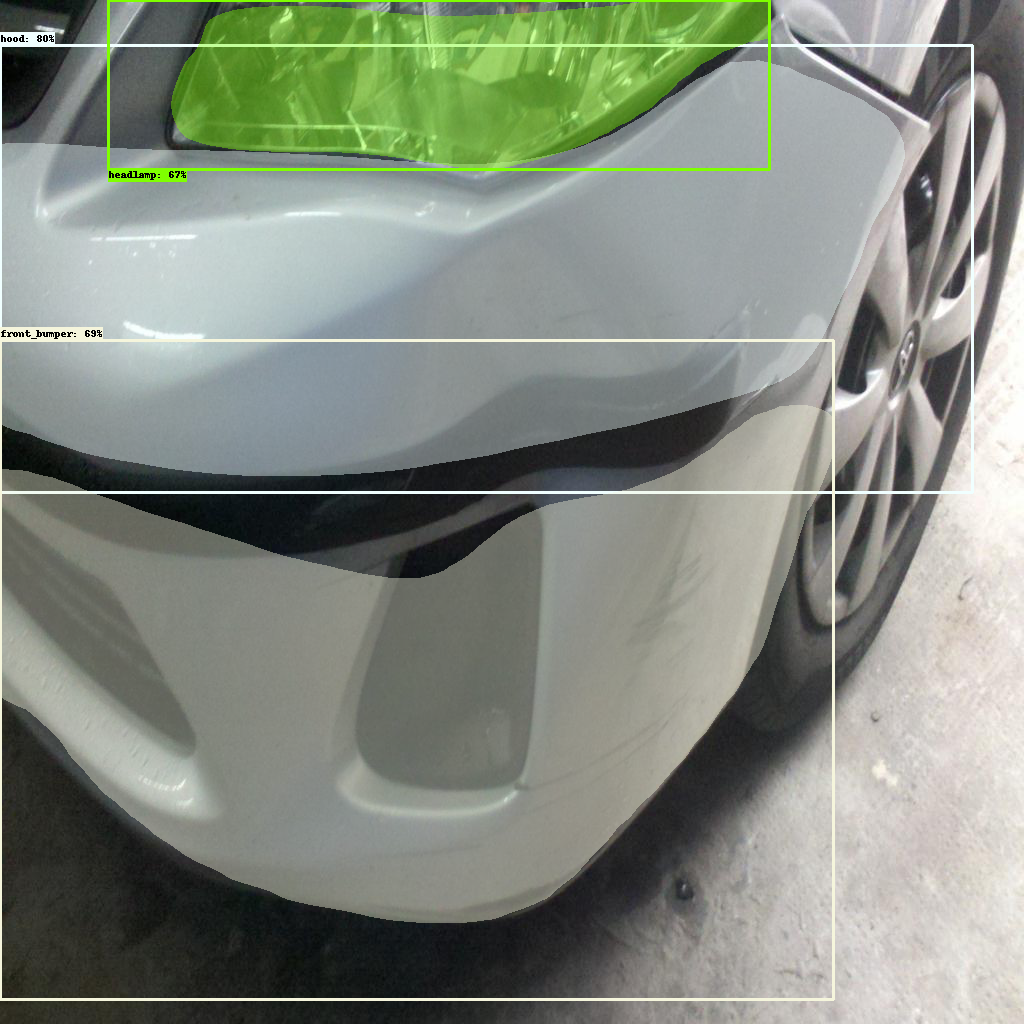

Running inference for :  /content/maskrcnn/data/test/60.jpg


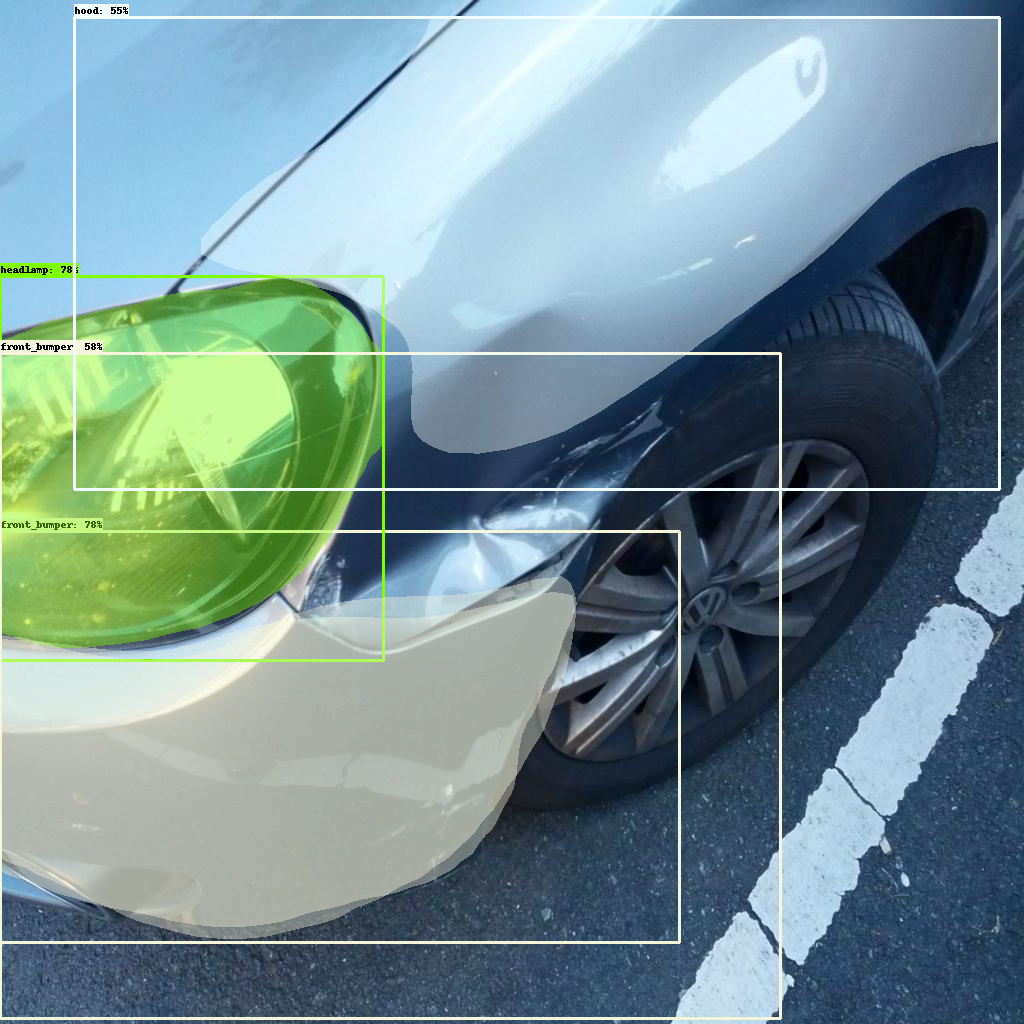

Running inference for :  /content/maskrcnn/data/test/66.jpg


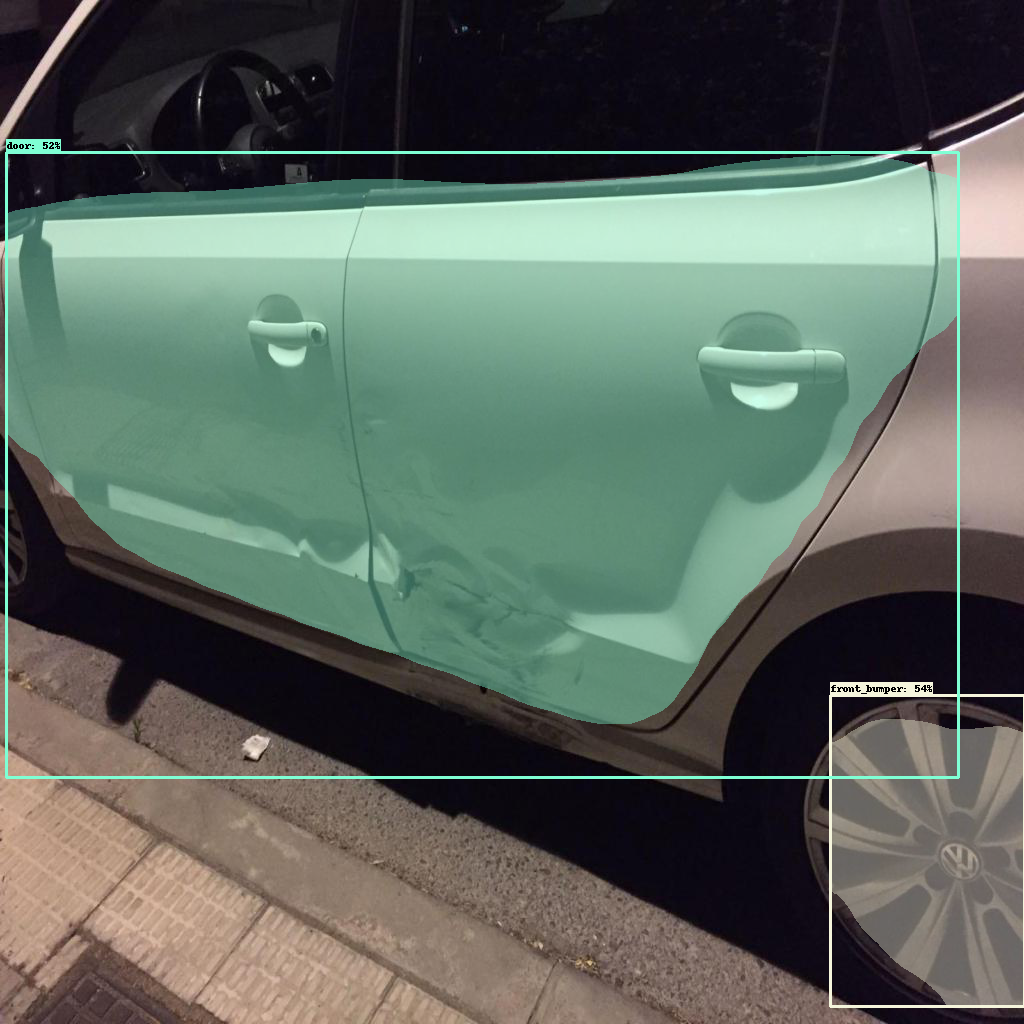

Running inference for :  /content/maskrcnn/data/test/67.jpg


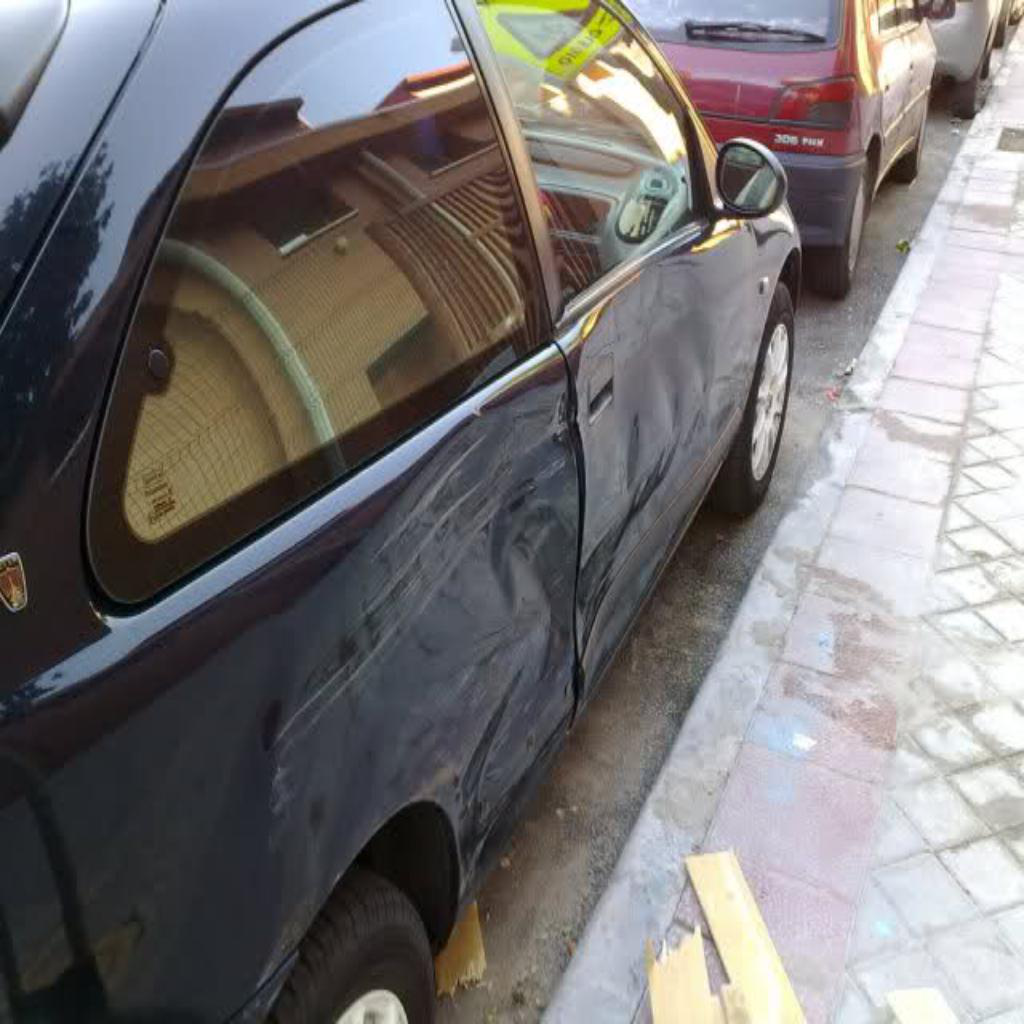

Running inference for :  /content/maskrcnn/data/test/72.jpg


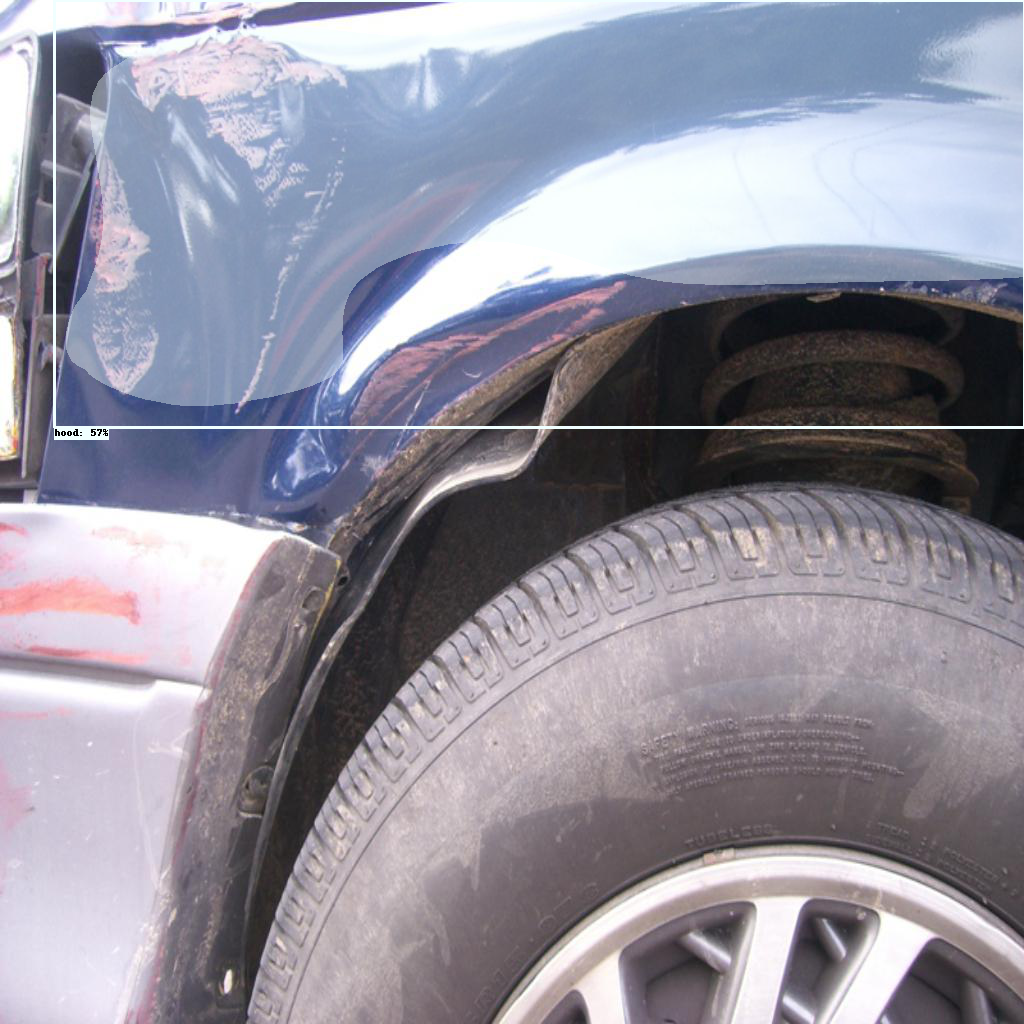

In [45]:
for image_path in TEST_IMAGE_PATHS:
    show_inference(masking_model, image_path)

## Where to go from here
Follow us on [LinkedIn](https://www.linkedin.com/company/mlnuggets), [Twitter](https://twitter.com/ml_nuggets), [GitHub](https://github.com/mlnuggets) and subscribe to our [blog](https://www.machinelearningnuggets.com/#/portal) so that you don't miss a new issue.